# Gradient TD(n)

In [1]:
%matplotlib notebook
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import tabulate
import numpy as np
import pandas as pd

In [2]:
import gym
from envs import MDP
from policies import Policy, UniformPolicy, RandomPolicy

In [3]:
env = gym.make('ThreeState-v0')
policy = RandomPolicy(env.n_nstates, env.action_space.n)

In [4]:
from algorithms.error_functions import mean_squared_value_error
from algorithms.error_functions import bellman_error
from algorithms.error_functions import td_error

msve = mean_squared_value_error(env, policy)
be = bellman_error(env, policy)
tde = td_error(env, policy)

In [5]:
from algorithms.closed_form import cf_policy_eval

v_pi = cf_policy_eval(env, policy)

print("Values: ", v_pi)
print(f"\nMSVE:           {msve(v_pi):.5f}")
print(f"Bellman Error:  {be(v_pi):.5f}")
print(f"TD Error:       {tde(v_pi):.5f}")

Values:  [-0.68023256 -0.36046512  1.04651163]

MSVE:           0.00000
Bellman Error:  0.00000
TD Error:       1.58285


In [6]:
assert env.n_states == 5 and env.n_nstates == 3

a, b = 1, 1
features = np.array([[1, 0], [0, 1], [a, b]], dtype=np.float)

In [23]:
from algorithms.closed_form import cf_minimum_msve
from algorithms.closed_form import cf_minimum_tderror
from algorithms.closed_form import cf_minimum_bellman

table = [["Values", "MSV Error", "Bellman Error", "TD Error"]]
error_fns = [msve, be, tde]

table.append(["v_pi"] + [np.round(x, decimals=7) for x in [err(v_pi) for err in error_fns]])

w_msve = cf_minimum_msve(env, policy, features)
v_msve = features @ w_msve
table.append(["min MSVE(w)"] + [np.round(x, decimals=7) for x in [err(v_msve) for err in error_fns]])

w_be = cf_minimum_bellman(env, policy, features)
v_be = features @ w_be
table.append(["min Bellman(w)"] + [np.round(x, decimals=7) for x in [err(v_be) for err in error_fns]])

w_td = cf_minimum_tderror(env, policy, features)
v_td = features @ w_td
table.append(["min TDerr(w)"] + [np.round(x, decimals=7) for x in [err(v_td) for err in error_fns]])

print(tabulate.tabulate(table, headers="firstrow"))

Values            MSV Error    Bellman Error    TD Error
--------------  -----------  ---------------  ----------
v_pi               0                0            1.58285
min MSVE(w)        0.273474         0.336611     1.81658
min Bellman(w)     0.43657          0.260458     1.85494
min TDerr(w)       0.31782          0.305187     1.72926


In [39]:
from typing import List, Tuple
def add_lines_to_plot(ax, values: List[Tuple[float, str, str]]):
    for value, label, color in values:
        ax.axhline(value, color=color, dashes=[6, 3], label=label)
        ax.text(1.02, value, label, va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
                transform=ax.get_yaxis_transform())

In [60]:
from algorithms.online_algorithms import GradientTDn
import multiprocessing as mp
import itertools
from sys import stdout

done = 0

def train(lrargs, n, semigradient, episodes_no, step, run_id):
    env = gym.make('ThreeState-v0')
    gtd = GradientTDn(env, policy, features,
                             lr=lrargs, n=n, semigradient=semigradient)
    results = gtd.train(episodes_no=episodes_no, step=step)
    data = pd.DataFrame({key: results[key]
                         for key in ["episode", "msve", "berr", "tderr", "err"]})
    data["lr"] = gtd.lr.__str__(precision=2)
    data["n"] = n
    data["semigradient"] = semigradient
    data["closed form"] = False
    data["run_id"] = run_id
    return data

def new_one(result):
    global done
    done += 1
    stdout.write(f'\r{done:d}')
    return result

pool = mp.Pool(8)
episodes_no = 50000
lrs = [{"name": "const", "value": value} for value in np.logspace(-3, -5, 6)]
ns = [1, 2, 3, 4, 5]
semigradient = [True, False]

args = itertools.product(lrs, ns, semigradient)

step = 25
async_results = [pool.apply_async(train, (lr, n, sg, episodes_no, step, run_id), callback=new_one)
                 for (lr, n, sg) in args for run_id in range(5)]
data = pd.concat([async_result.get() for async_result in async_results], sort=False)
pool.close()
del pool
print("done")

300done


In [58]:
print(len(data[data.semigradient == False]))

30000


<IPython.core.display.Javascript object>


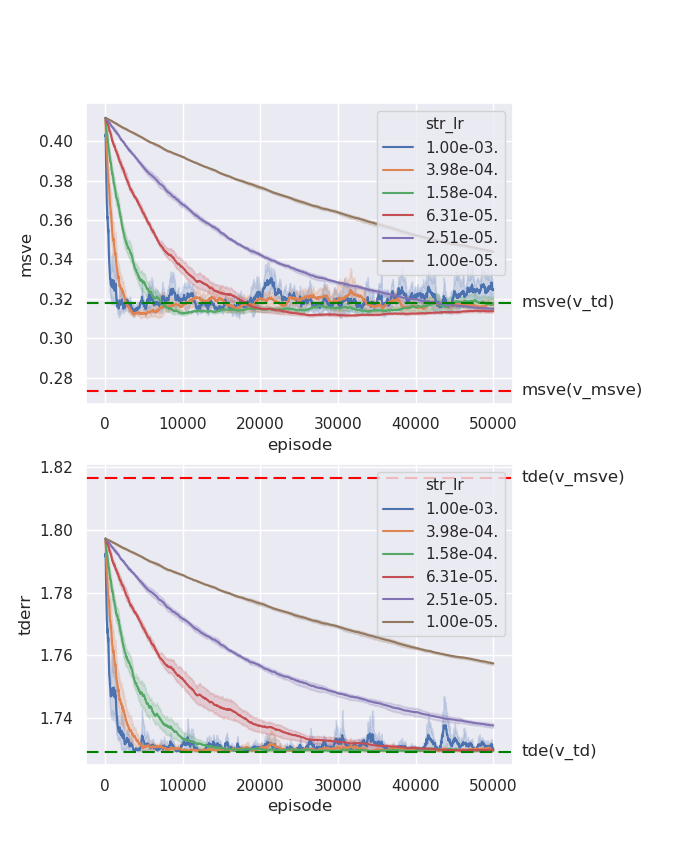

In [64]:
SEMIGRADIENT = False

data["str_lr"] = data.lr.apply(lambda x: x + ".")
lrs = [(v, float(v[:-1])) for v in data.str_lr.unique()]
sort(lrs, key=lambda x: x[1])
lrs = [l[0] for l in lrs]
plot_data = data[(data.n == 1) & (data.semigradient == False)]

fig = plt.figure()
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1.5})

ax = fig.add_subplot(211)
ax = sns.lineplot(data=plot_data, x="episode", y="msve",
                  hue="str_lr", hue_order=lrs, ax=ax)
add_lines_to_plot(ax, [(msve(v_td), "msve(v_td)", "green"),
                       (msve(v_msve), "msve(v_msve)", "red"),
                       ])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax = fig.add_subplot(212)
ax = sns.lineplot(data=plot_data, x="episode", y="tderr",
                  hue="str_lr", hue_order=lrs, ax=ax)
add_lines_to_plot(ax, [(tde(v_td), "tde(v_td)", "green"),
                       (tde(v_msve), "tde(v_msve)", "red"),
                       ])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

<IPython.core.display.Javascript object>


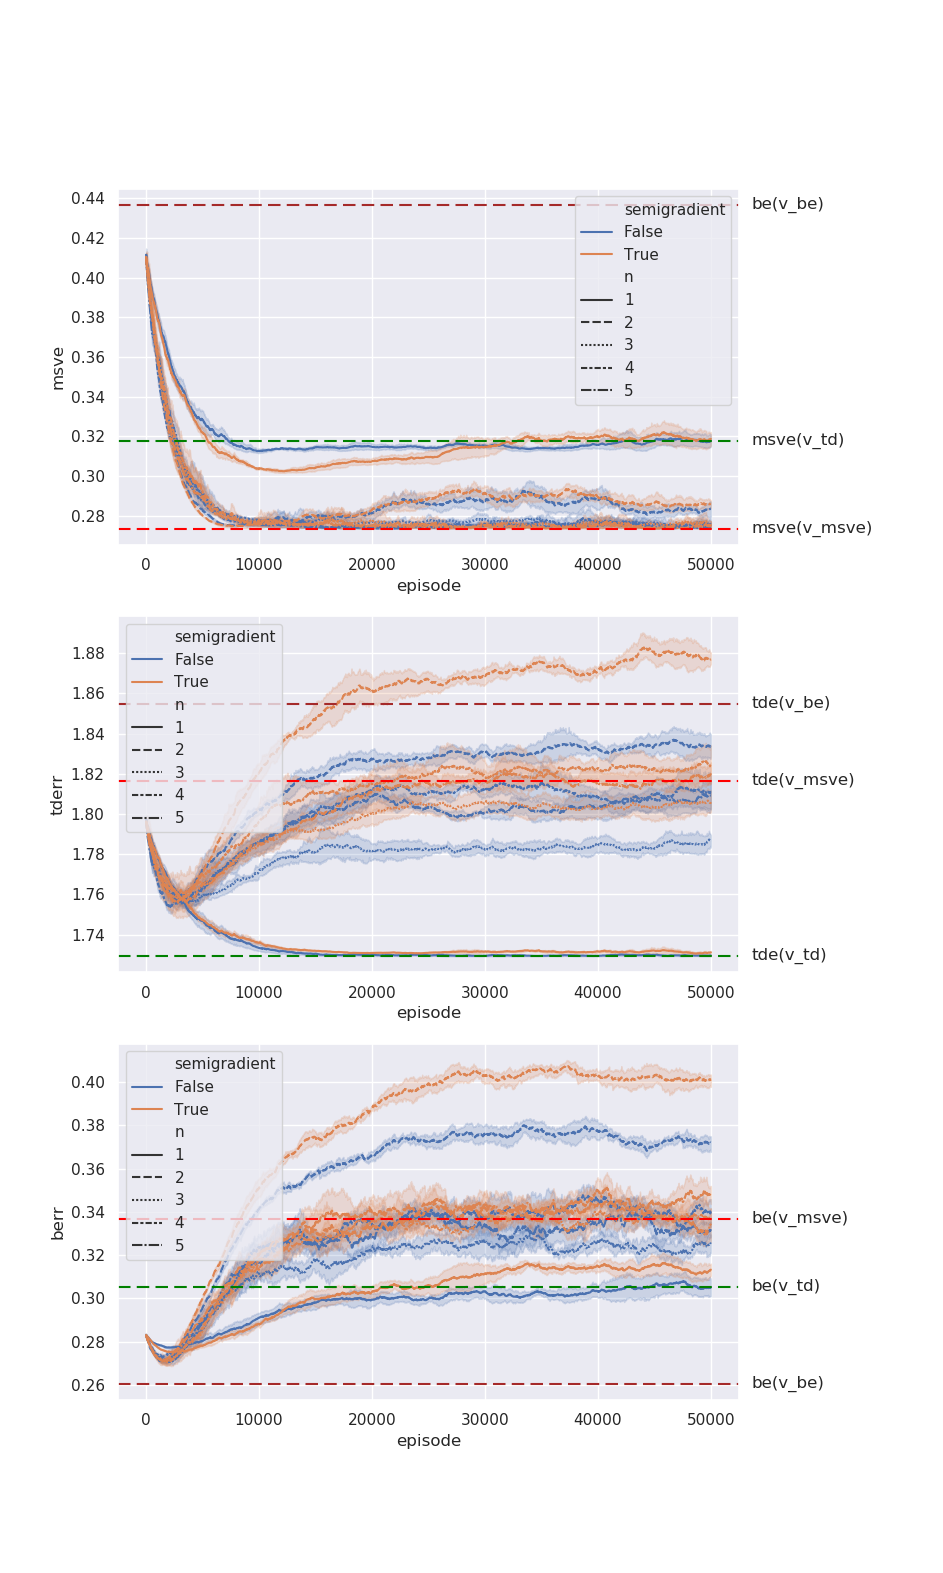

In [68]:
SEMIGRADIENT = True

data["str_lr"] = data.lr.apply(lambda x: x + ".")
plot_data = data[(data.str_lr == '1.58e-04.')]

fig = plt.figure()
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1.5})

ax = fig.add_subplot(311)
ax = sns.lineplot(data=plot_data, x="episode", y="msve",
                  hue="semigradient", style="n", ax=ax)
add_lines_to_plot(ax, [(msve(v_td), "msve(v_td)", "green"),
                       (msve(v_be), "msve(v_be)", "brown"),
                       (msve(v_msve), "msve(v_msve)", "red"),
                       ])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])

ax = fig.add_subplot(312)
ax = sns.lineplot(data=plot_data, x="episode", y="tderr",
                  hue="semigradient", style="n", ax=ax)
add_lines_to_plot(ax, [(tde(v_td), "tde(v_td)", "green"),
                       (tde(v_be), "tde(v_be)", "brown"),
                       (tde(v_msve), "tde(v_msve)", "red"),
                       ])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])


ax = fig.add_subplot(313)
ax = sns.lineplot(data=plot_data, x="episode", y="berr",
                  hue="semigradient", style="n", ax=ax)
add_lines_to_plot(ax, [(be(v_td), "be(v_td)", "green"),
                       (be(v_be), "be(v_be)", "brown"),
                       (be(v_msve), "be(v_msve)", "red"),
                       ])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])